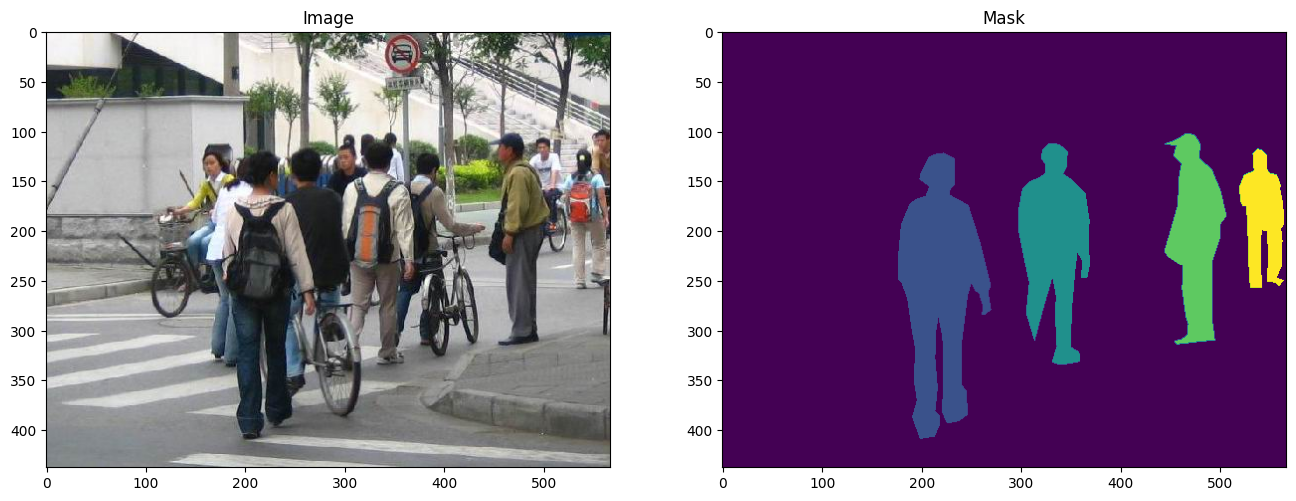

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("C:/Users/rachel/Downloads/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("C:/Users/rachel/Downloads/PennFudanPed/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [3]:
import os
os.chdir( 'C:/Users/rachel/seadrive_root/Rachel/My Libraries/Rachel/Capstone/Hydroponics')

from roboflow import Roboflow
rf = Roboflow(api_key="TDzWYbzsPAcvmYddwTT3")
project = rf.workspace("hydroponics-cuihh").project("pest-types")
version = project.version(8)
dataset = version.download("coco")



loading Roboflow workspace...
loading Roboflow project...


In [4]:
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
from torchvision.models.detection import (
    fasterrcnn_mobilenet_v3_large_fpn,
    FasterRCNN_MobileNet_V3_Large_FPN_Weights,
)

In [6]:
NUM_CLASSES = 4  # background=0 included, Suzanne = 1

def get_faster_rcnn_model(num_classes):
    """return model and preprocessing transform"""
    model = fasterrcnn_mobilenet_v3_large_fpn(
        weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    )
    model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.cls_score.in_features,
        out_features=num_classes,
        bias=True,
    )
    model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.bbox_pred.in_features,
        out_features=num_classes * 4,
        bias=True,
    )
    preprocess = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT.transforms()
    return model, preprocess


model, preprocess = get_faster_rcnn_model(num_classes=NUM_CLASSES)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [7]:
print(model.transform)


GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)


In [8]:
import json
from collections import defaultdict
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset


class CocoDataset(Dataset):
    """PyTorch dataset for COCO annotations."""

    # adapted from https://github.com/pytorch/vision/issues/2720

    def __init__(self, root, annFile, transform=None):
        """Load COCO annotation data."""
        self.data_dir = Path(root)
        self.transform = transform

        # load the COCO annotations json
        anno_file_path = annFile
        with open(str(anno_file_path)) as file_obj:
            self.coco_data = json.load(file_obj)
        # put all of the annos into a dict where keys are image IDs to speed up retrieval
        self.image_id_to_annos = defaultdict(list)
        for anno in self.coco_data["annotations"]:
            image_id = anno["image_id"]
            self.image_id_to_annos[image_id] += [anno]

    def __len__(self):
        return len(self.coco_data["images"])

    def __getitem__(self, index):
        """Return tuple of image and labels as torch tensors."""
        image_data = self.coco_data["images"][index]
        image_id = image_data["id"]
        image_path = self.data_dir / image_data["file_name"]
        image = Image.open(image_path)

        annos = self.image_id_to_annos[image_id]
        anno_data = {
            "boxes": [],
            "labels": [],
            "area": [],
            "iscrowd": [],
        }
        for anno in annos:
            coco_bbox = anno["bbox"]
            left = coco_bbox[0]
            top = coco_bbox[1]
            right = coco_bbox[0] + coco_bbox[2]
            bottom = coco_bbox[1] + coco_bbox[3]
            area = coco_bbox[2] * coco_bbox[3]
            anno_data["boxes"].append([left, top, right, bottom])
            anno_data["labels"].append(anno["category_id"])
            anno_data["area"].append(area)
            anno_data["iscrowd"].append(anno["iscrowd"])

        target = {
            "boxes": torch.as_tensor(anno_data["boxes"], dtype=torch.float32),
            "labels": torch.as_tensor(anno_data["labels"], dtype=torch.int64),
            "image_id": torch.tensor([image_id]),
            "area": torch.as_tensor(anno_data["area"], dtype=torch.float32),
            "iscrowd": torch.as_tensor(anno_data["iscrowd"], dtype=torch.int64),
        }

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [9]:
import random
import torchvision.transforms as T
from IPython.display import display
from PIL import ImageDraw

# create datasets
training_dataset = CocoDataset(
    root="C:/Users/rachel/seadrive_root/Rachel/My Libraries/Rachel/Capstone/Hydroponics/Pest-types-8/train",
    annFile="C:/Users/rachel/seadrive_root/Rachel/My Libraries/Rachel/Capstone/Hydroponics/Pest-types-8/train/_annotations.coco.json",
    transform=preprocess,
)
validation_dataset = CocoDataset(
    root="C:/Users/rachel/seadrive_root/Rachel/My Libraries/Rachel/Capstone/Hydroponics/Pest-types-8/valid",
    annFile="C:/Users/rachel/seadrive_root/Rachel/My Libraries/Rachel/Capstone/Hydroponics/Pest-types-8/valid/_annotations.coco.json",
    transform=preprocess,
)



In [10]:
print(f"training dataset size: {training_dataset.__len__()}")


print(f"validation dataset size: {validation_dataset.__len__()}")


training dataset size: 2181
validation dataset size: 170


random training label: {'boxes': tensor([[ 81.,  42., 176., 174.],
        [267., 193., 382., 493.],
        [187., 391., 252., 454.]]), 'labels': tensor([2, 2, 2]), 'image_id': tensor([449]), 'area': tensor([12540., 34500.,  4095.]), 'iscrowd': tensor([0, 0, 0])}


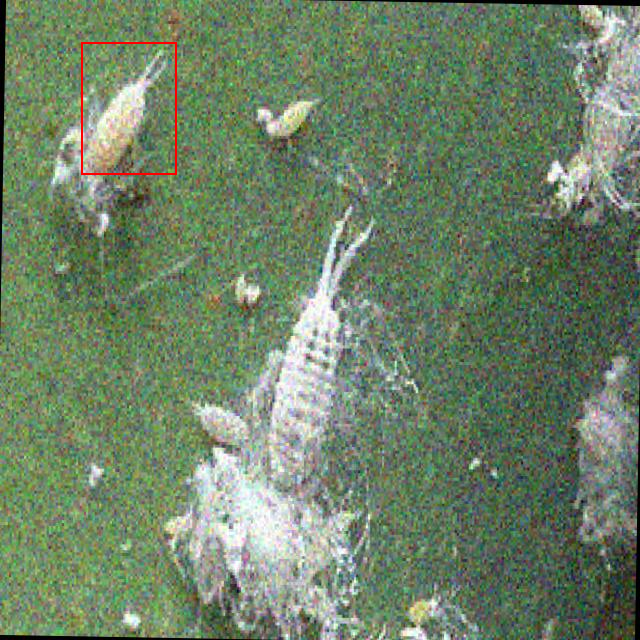

In [13]:
# get a random training sample
img, label = training_dataset[random.randint(0, len(training_dataset) - 1)]
print(f"random training label: {label}")

# display image with bbox label
transform = T.ToPILImage()
img = transform(img)
x1, y1, x2, y2 = label["boxes"].numpy()[0]
draw = ImageDraw.Draw(img)
draw.rectangle([x1, y1, x2, y2], fill=None, outline="#ff0000cc", width=2)
display(img)

In [11]:
BATCH_SIZE = 4

def collate(batch):
    """return tuple data"""
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate,
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate,
)

In [12]:
X, y = next(iter(validation_loader)) # get a validation batch

model.eval() # set the model in evaluation mode
with torch.no_grad(): # do not compute gradients
    X = [x.to(device) for x in X] # move images to device
    out = model(X) # model forward pass
    print(out)



In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
optimizer = torch.optim.SGD(
    params, 
    lr=0.00001, 
    momentum=0.9, 
    weight_decay=0.0001
)

In [ ]:
num_epochs = 10
train_loss_list = []
validation_loss_list = []
model.train() # set model in training mode
for epoch in range(num_epochs):
    N = len(train_loader.dataset)
    current_train_loss = 0
    # train loop
    for images, targets in train_loader:
        # move data to device and build the right input format for our model
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        current_train_loss += losses
    train_loss_list.append(current_train_loss / N)

    # validation loop
    N = len(validation_loader.dataset)
    current_validation_loss = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = list(image.to(device) for image in images)
            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                }
                for t in targets
            ]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            current_validation_loss += losses
    validation_loss_list.append(current_validation_loss / N)

    print(f"epoch: {epoch}")
    print(
        f"train loss: {train_loss_list[-1]}, validation loss: {validation_loss_list[-1]}"
    )

In [ ]:
torch.save(model, "./models/model.pth") # save model to file

# plot losses
train_loss = [x.cpu().detach().numpy() for x in train_loss_list]
validation_loss = [x.cpu().detach().numpy() for x in validation_loss_list]

plt.plot(train_loss, "-o", label="train loss")
plt.plot(validation_loss, "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [ ]:
model = torch.load("./models/model.pth")

def inference(img, device, model):
    model.eval()
    with torch.no_grad():
        pred = model([img.to(device)]) # forward pass

    # display image with bbox
    transform = T.ToPILImage()
    img = transform(img)
    x1, y1, x2, y2 = pred[0]["boxes"].cpu().detach().numpy()[0]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x1, y1, x2, y2], fill=None, outline="#ff0000cc", width=2)
    display(img)
    return pred

In [ ]:
img, _ = validation_dataset[random.randint(0, len(validation_dataset) - 1)]
>> inference(img, device, model)
